## Plot the generated daily soil and runoff cation concentrations

In [1]:
import os
import xarray as xr
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shared_read_HBR import *
from matplotlib import rcParams

folder = 'ERW_20240310_HBR_1_ICB20TRCNPRDCTCBC'
#folder = 'ERW_20231110_UC_Davis_ICB20TRCNPRDCTCBC'

rcParams['font.size'] = 16
rcParams['axes.titlesize'] = 18

In [2]:
path_to_files = os.path.join(os.environ['PROJDIR'], 'E3SM', 'output', folder, 'run')
hr = xr.open_mfdataset(glob(os.path.join(path_to_files, '*.elm.h1.*.nc')))
tvec = [pd.Timestamp(year=t.year, month=t.month, day=t.day) for t in hr['time'].values]

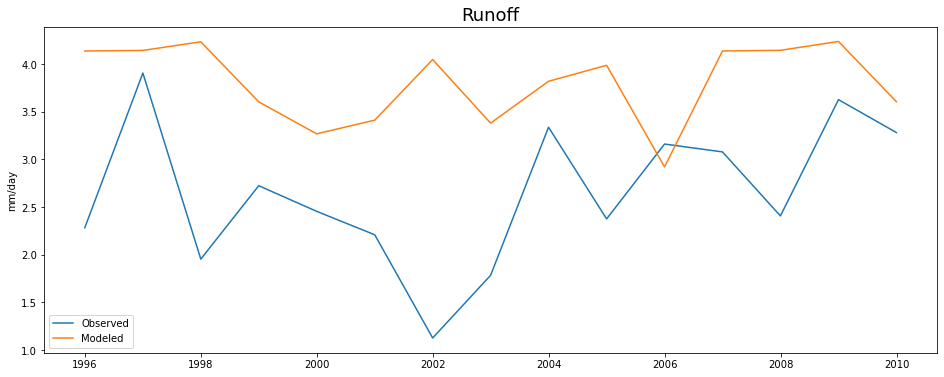

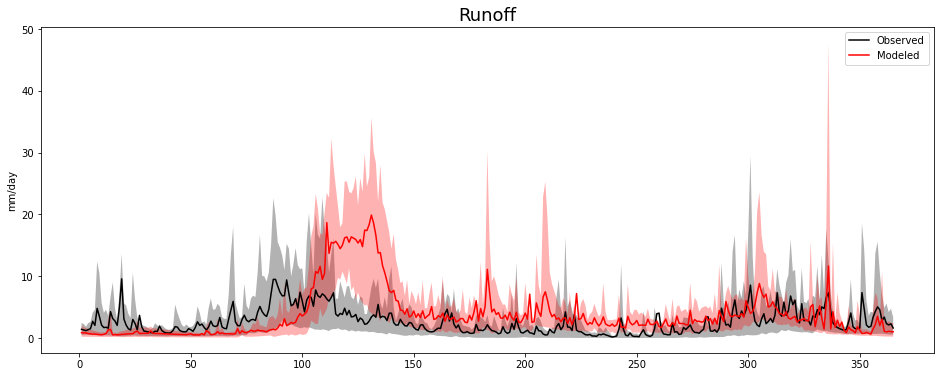

In [3]:
runoff_obs = read_runoff() # mm/day
runoff_sim = pd.Series(
    hr['QRUNOFF'][:-1, 0] * 86400, 
    index = tvec[:-1]
)

# annual time series
fig, ax = plt.subplots(figsize = (16,6))
obs_ann = runoff_obs[runoff_sim.index].resample('1Y').mean()
sim_ann = runoff_sim[runoff_sim.index].resample('1Y').mean()
ax.plot(obs_ann.index, obs_ann, label = 'Observed')
ax.plot(sim_ann.index, sim_ann, label = 'Modeled')
ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff_annual.png', dpi = 600., bbox_inches = 'tight')


# daily annual cycle
fig, ax = plt.subplots(figsize = (16,6))

obs_box = runoff_obs.loc[runoff_sim.index].values.reshape(-1, 365)
ax.plot(range(1, 366), obs_box.mean(axis = 0), '-k', label = 'Observed')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(obs_box, 10, axis = 0),
    np.nanpercentile(obs_box, 90, axis = 0), 
    fc = 'k', alpha = 0.3
)

sim_box = runoff_sim.loc[runoff_sim.index].values.reshape(-1, 365)
ax.plot(range(1, 366), sim_box.mean(axis = 0), '-r', label = 'Modeled')
ax.fill_between(
    range(1, 366),
    np.nanpercentile(sim_box, 10, axis = 0),
    np.nanpercentile(sim_box, 90, axis = 0), 
    fc = 'r', alpha = 0.3
)

ax.set_xlabel('')
ax.set_ylabel('mm/day')
ax.legend()
ax.set_title('Runoff')
plt.savefig('./temp/hbr_runoff.png', dpi = 600., bbox_inches = 'tight')

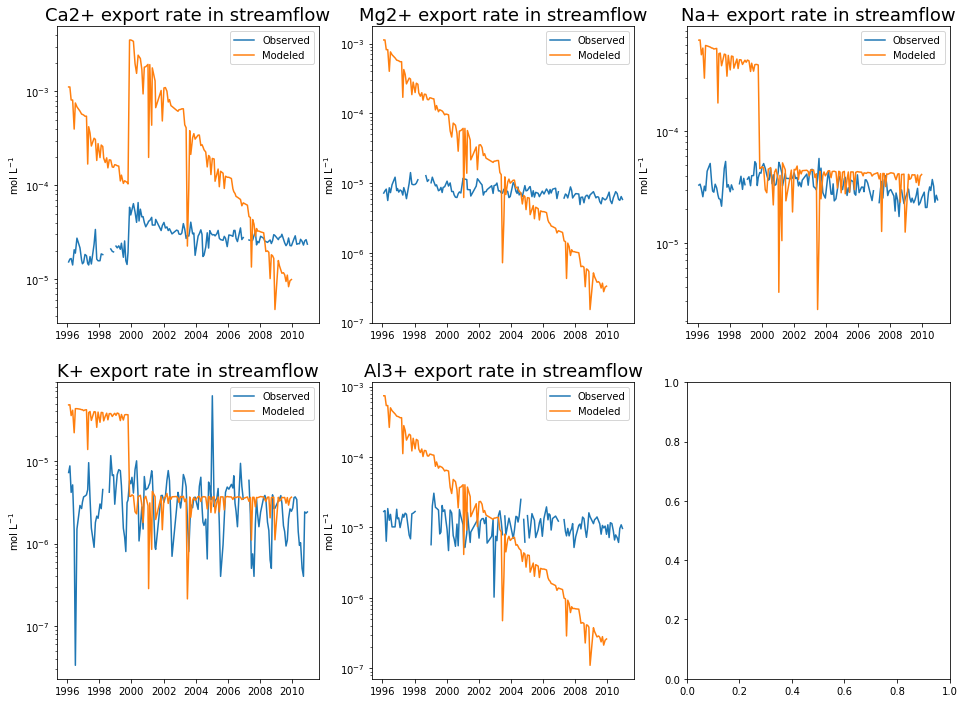

In [10]:
# cation_export_obs = convert_streamChem(read_streamChem())
cation_export_obs = read_streamChem() * 1e-6 # umol/L -> mol/L

cation_export_sim = pd.DataFrame(
    (hr['cation_leached'][:, :, 0] + hr['cation_runoff'][:, :, 0]) / \
    (hr['QRUNOFF'] + hr['QDRAI'])[:,0].values.reshape(-1,1),
    index = tvec, columns = ['Ca2+','Mg2+','Na+','K+','Al3+'])

cation_export_sim = cation_export_sim.loc[
    cation_export_obs.index.intersection(cation_export_sim.index), :]

cation_export_obs = cation_export_obs.loc[
    (cation_export_obs.index.year >= 1996) & 
    (cation_export_obs.index.year <= 2010)]
cation_export_sim = cation_export_sim.loc[
    (cation_export_sim.index.year >= 1996) & 
    (cation_export_sim.index.year <= 2010), :]

fig, axes = plt.subplots(2, 3, figsize = (16, 12))
for i, (obs_ca, sim_ca, mass_ca) in enumerate(
    zip(['Ca2', 'Mg2', 'Na', 'K', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'],
        [40, 24, 23, 29, 27])
):
    ax = axes.flat[i]

    ax.plot(cation_export_obs.index, cation_export_obs[obs_ca], label = 'Observed')
    ax.plot(cation_export_sim.index, cation_export_sim[sim_ca] / mass_ca, label = 'Modeled')

    ax.set_xlabel('')
    ax.set_ylabel('mol L$^{-1}$')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'{sim_ca} export rate in streamflow')
plt.savefig('./temp/hbr_cation_export.png', dpi = 600., bbox_inches = 'tight')

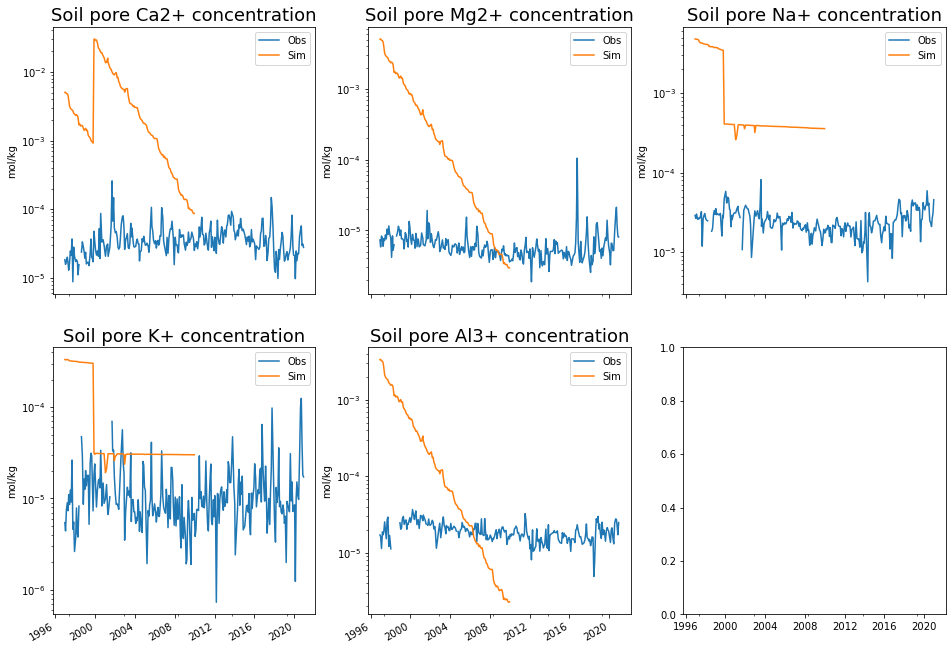

In [9]:
soil_pore_obs = read_lysimeter()

# calcium: convert from g m-3 soil to mol/kg porewater
soil_pore_sim = {}
for i, (cation, mass_ca) in \
    enumerate(zip(['Ca2+','Mg2+','Na+','K+','Al3+'], 
                  [40, 24, 23, 29, 27])):
    soil_pore_sim[cation] = pd.Series( 
        ((hr[f'cation_vr_{i+1}'][:,:6,0] / hr['H2OSOI'][:,:6,0] / mass_ca / 1000) *
        hr['levgrnd'].values[:6].reshape(1,-1)).sum(axis = 1) / hr['levgrnd'].values[:6].sum(), 
        index = tvec)
soil_pore_sim = pd.DataFrame(soil_pore_sim)
soil_pore_sim = soil_pore_sim.loc[
    soil_pore_sim.index.intersection(soil_pore_obs.index)]


fig, axes = plt.subplots(2, 3, figsize = (16, 12), sharex = True)
for i, (obs_ca, sim_ca) in enumerate(
    zip(['Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt'],
        ['Ca2+','Mg2+','Na+','K+','Al3+'])
):
    ax = axes.flat[i]
    soil_pore_obs[obs_ca].plot(ax = ax, label = 'Obs')
    soil_pore_sim[sim_ca].plot(ax = ax, label = 'Sim')
    ax.set_xlabel('')
    ax.set_ylabel('mol/kg')
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'Soil pore {sim_ca} concentration')
fig.savefig('./temp/hbr_soil_pore_water.png', dpi = 600., bbox_inches = 'tight')

In [6]:
# Calculate the total concentration of added cations as bicarbonate alkalinity
# (1) pre-treatment (pre-2019: bicarbonate alkalinity)
# (2) during-treatment (2019-autumn 2020)
# (3) post-treatment (winter 2020-2021)

zsoi = np.insert((hr['levgrnd'].values[:-1] + hr['levgrnd'].values[1:]) / 2, 0, 0)
zsoi = np.insert(zsoi, -1, hr['levgrnd'].values[-1] + 
                0.5 * (hr['levgrnd'].values[-1] - hr['levgrnd'].values[-2]))
thickness = np.diff(zsoi)

alkalinity = np.zeros([len(hr['time']), 2])

for i, mixing_depth in enumerate([0.15, 0.3]):
    weight = np.where(zsoi[:-1] < mixing_depth, np.minimum(thickness, mixing_depth - zsoi[:-1]), 0)
    for n in range(1,6):
        # keep the g m-3 unit = mg L-1
        temp = np.sum(hr[f'cation_vr_{n}'][:,:,0] * weight.reshape(1, -1), 
                      axis = 1) / np.sum(weight)
        if n in [1,2]:
            # Ca2+, Mg2+
            alkalinity[:, i] = alkalinity[:, i] + 2 * temp
        elif n in [3, 4]:
            alkalinity[:, i] = alkalinity[:, i] + temp
        else:
            alkalinity[:, i] = alkalinity[:, i] + 3 * temp


Text(0, 0.5, 'bicarbonate alkalinity')

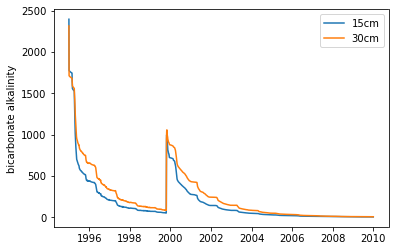

In [7]:
plt.plot(tvec, alkalinity)
plt.legend(['15cm', '30cm'])
plt.ylabel('bicarbonate alkalinity')

In [8]:
hr.close()